# **Is there a reasonable (physical) interpretation of neural network weights - or is this even a thing to care about?**

## **Maybe yes, maybe no, definitely sometimes**





## **NOTES:**

- Okay .... I'm just going to assume everybody knows some basics of NNets
- I ended up going down this path because of the work I was doing when I started working

### NNet weights - the innocent explanation

**Most of the "stuff" I've seen has described NNet weights in the following way**

- The neurons in a neural network are like the neurons of the brain 
  - Disclaimer: I'm not a neurologist, but I hear this isn't really accurate

- The weights between the neurons represent the "connection strength" between neurons.
  - Now ... maybe accurate, but:
    - Connections between "what"
    - Isn't there some better explanation

### Point of this little presentation: Indeed, one can sometimes understand/interpret these NNet neurons in a physically meaningful way 

## Simple case 1:

![Simple Circle](./resources/simple_example.svg "Simple Circle Example")


So ... let's investigate a little toy problem.
In this problem we have a function where points are "inside the ring" or "outside the ring"
Let's see if we can recover the simple function (hint we know it, it's obvious) with a baby nnet ... and see what we learn.

Oh, btw: I'll be measuring the angles here in: $\tau = 2.rad = 360\deg$

In [1]:
# Imports and setup

from numpy import cos, logical_and, sin, stack, pi as PI, round
from numpy.random import rand, seed

from sklearn.neural_network import MLPClassifier

from sympy import init_printing, Matrix, symbols
from sympy.functions.elementary.piecewise import Piecewise
from sympy.functions.elementary.exponential import exp
from sympy.plotting.plot import plot
from sympy.printing import pprint
from sympy.simplify import simplify

init_printing()

TRAIN_SIZE = 10000
TEST_SIZE = 2000
INNER_SIZE=0.5
OUTER_SIZE=0.6

### Training and test coordinates in Spherical/Polar coordinates

In [2]:
pol_train = rand(TRAIN_SIZE, 2)
pol_test = rand(TEST_SIZE, 2)

train_sol = logical_and(INNER_SIZE <= pol_train[:, 0], pol_train[:, 0] <= OUTER_SIZE).astype(int)
test_sol = logical_and(INNER_SIZE <= pol_test[:, 0], pol_test[:, 0] <= OUTER_SIZE).astype(int)

### And in Cartesian coordinates

In [3]:
xy_train = stack(
    (
        pol_train[:, 0] * cos(2 * pol_train[:, 1]),
        pol_train[:, 0] * sin(2 * pol_train[:, 1]),
    ),
    axis=1,
)
xy_test = stack(
    (
        pol_test[:, 0] * cos(2 * pol_test[:, 1]),
        pol_test[:, 0] * sin(2 * pol_test[:, 1]),
    ),
    axis=1,
)

### Okay let's train our little network in polar coordinates

In [4]:
seed(15)
pol_clf = MLPClassifier(
    hidden_layer_sizes=(2,),
    activation="relu",
    solver="lbfgs",
    max_iter=2000,
    tol=0.000001,
    alpha=0,
)
pol_clf.fit(pol_train, train_sol)
print(f"Loss: {pol_clf.loss_}")
print(f"Test score: {pol_clf.score(pol_test, test_sol)}")

Loss: 2.0598994096204845e-09
Test score: 0.9995


**Cool, let's look at our weights and biases for the 2 layers of connections**

In [5]:
print("Weights:")
for idx, weight in enumerate(pol_clf.coefs_):
    print(f"Layer {idx}:")
    print("\t{}".format(str(weight).replace("\n", "\n\t")))

print("Biases:")
for idx, bias in enumerate(pol_clf.intercepts_):
    print(f"Layer {idx}:")
    print("\t{}".format(str(bias).replace("\n", "\n\t")))

Weights:
Layer 0:
	[[ 7.66819542e+02 -4.42665991e+02]
	 [-1.00513087e+00  7.08175869e-02]]
Layer 1:
	[[-533.3279756 ]
	 [-330.69901043]]
Biases:
Layer 0:
	[-458.57175954  222.95733456]
Layer 1:
	[548.96814356]


Wow ... (well not really so surprising) ... there's like 4 orders of magnitude difference in the contributions between the $r$ terms and $\theta$ terms.

Let's do some simple rounding, write out the equations, and plot the simple graphs:

In [6]:
input_vals = Matrix([symbols("r θ")])
pol_coefs = [round(_, 0) for _ in pol_clf.coefs_]
pol_ints = [round(_, 0) for _ in pol_clf.intercepts_]
layer_0_top, layer_0_bottom = input_vals * Matrix(pol_coefs[0]) + Matrix(pol_ints[0]).transpose()

print("Layer 0 before activation:")
pprint(layer_0_top)
pprint(layer_0_bottom)

Layer 0 before activation:
767.0⋅r - θ - 459.0
223.0 - 443.0⋅r


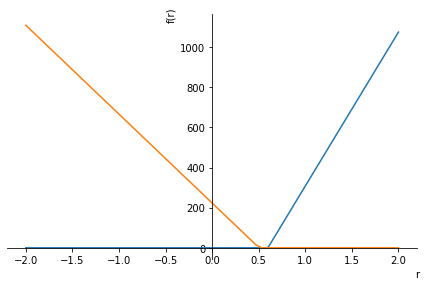

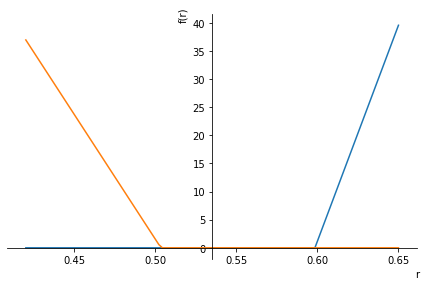

⎡⎧767.0⋅r - 459.0  for 767.0⋅r > 459.0  ⎧223.0 - 443.0⋅r  for r < 0.503386004514673⎤
⎢⎨                                      ⎨                                          ⎥
⎣⎩       0              otherwise       ⎩       0                 otherwise        ⎦

In [12]:
layer_0 = Matrix(
    [
        [
            Piecewise((layer_0_top, simplify(layer_0_top > 0)), (0, True)),
            Piecewise((layer_0_bottom, simplify(layer_0_bottom > 0)), (0, True))
        ]
    ]
)
layer_0=layer_0.subs("θ", 0)
layer_0

plot(*layer_0, (symbols("r"), -2, 2))
plot(*layer_0, (symbols("r"), 0.42, 0.65))
layer_0

So ... we can definitely see something different is happening between $~0.5$ and $~0.5$.
Let's go through the rest and see what pops out.

In [13]:
layer_1_pre_activation=simplify((layer_0*Matrix(pol_coefs[1]) + Matrix(pol_ints[1]))[0])

layer_1=simplify(Piecewise((layer_1_pre_activation, layer_1_pre_activation > 0), (0, True)))
layer_1

⎧⎧146633.0⋅r - 73264.0   for r < 0.503386004514673                                                   
⎪⎪                                                                                                   
⎪⎨245196.0 - 408811.0⋅r  for r > 0.598435462842242  for r > 0.499641963268841 ∧ r < 0.599778381697166
⎨⎪                                                                                                   
⎪⎩        549.0                  otherwise                                                           
⎪                                                                                                    
⎩                        0                                              otherwise                    

Let's plot this and binarize

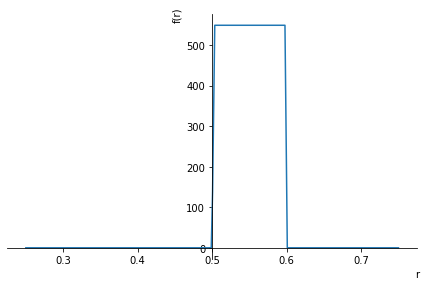

Binarized output:
⎧1  for r > 0.499641963268841 ∧ r < 0.599778381697166
⎨                                                    
⎩0                      otherwise                    


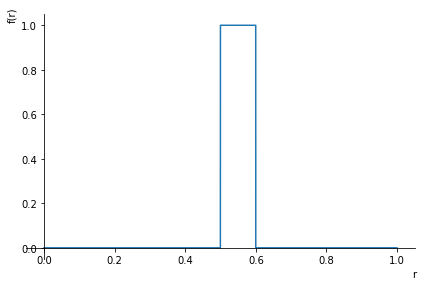

In [14]:
plot(layer_1, (symbols("r"), 0.25, 0.75))
binarized_output = simplify(Piecewise((1, layer_1 > 0), (0, True)))
print("Binarized output:")
pprint(binarized_output)
plot(binarized_output, (symbols("r"), 0, 1))

#### Surprise surprise, we've recoverd our "original" eqution

- One cannot really replicate this with cartesian co-ordinates
    - Think about encoding:  $r_0^2 <= x^2 + y ^2 <= r_1^2$
- One does not get nice simple results if you don't use `relu` as the activation function
    - The nice (mathematically `unsmooth`, `continuous`) edges, which the other SciPy activation functions don't have, are needed
- **In certain conditions one can get meaningful information from the weights/biases of the NNet rather than just from the output layer**
    - In the above scenario the two components of the original equation ($x >= 0.5$ and $x<=0.6$) can more-or-less just be read off straight from the weights.

**So, what do we learn?**

- The way one encodes the problem is important
- Architecting the NNet so that it reflects what's happening in the problem can dramatically simplify things 
    - With the cartesian co-ordinates something like 2 - 3 layers of 6 - 8 neurons were needed for good accuracy (still worse accuracy, though, that one 2-neuron layer with polar coordinates).
- **In some circumstances it is possible to get meaningful information from the weights of the NNet**

## Part 2:

Q: What did I start off doing?

A: Building seismic models for mines.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

t = 1.0024999999999897


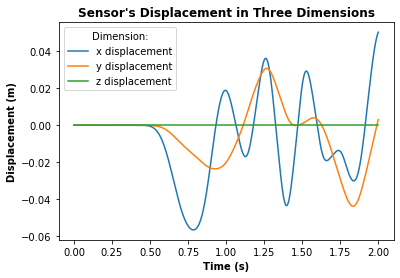

In [15]:
import lattice_v2
lattice_v2.run_sim()


### What does this look like if we plot things slightly differently?


Sorry: I was unable to put this together ... hopefully you can see it in your mind's eye, though.

**The imagining:**

- How would this look if we plotted the nodes of the model not spatially, _but according to the time at which they first deviated from their rest state_ (i.e. time ordered)?
- I hope in your imagination it looks something like this:

<img src="./resources/silly_mlp.jpg" alt="Silly small MLP example" width="200"/>


**Am I lying to you?**

Well, you can decide for yourself. Let's take some sentences from an important paper$^{[1]}$.

- Lailly and Tarantola recast the migration imaging principle ... as a local optimization problem, the aim of which is least-squares minimization of the misfit between recorded and modeled data.
- ... the gradient of the misfit function ... can be built by crosscorrelating the incident wavefield ... and the back-propagated residual wavefields.
- As widely stressed, FWI is an ill-posed problem, meaning that an infinite number of models matches the data. Some regularizations are conventionally applied to the inversion to make it better posed.
- Alternatively, the inverse of the Hessian in equation 11 can be replaced by a scalar $\alpha$, the so-called step length, leading to the gradient or steepest-descent method.

**So the keywords are:**
- Forward-problem
- Back propogation
- Gradient descent
- Regularization

**Does this sound familiar?**

Going through the calculations, one finds that, indeed, it is extremely similar to "normal" NNets (though somewhat more involved).

- Below is a successful (though synthetic) example of one of my inversions:

In [16]:
from IPython.display import Video

Video("./resources/Beta_Inversion.mp4", width=600)

### Is seismology a special case here?

- No
- Without hardly any effort I dug up a paper $^{[2]}$ using the same technique but for robotic arms (in reinforcement learning):
    - In this case the control equations for the robotic arm were the governing equations of the NNet
    - The parameters estimated were the parameters the robotic arm needed to operate as desired
- Then I found this gem $^{[3]}$
    - This demonstrates that a technique like this can be applied in many cases where the equations controlling the system are known


### Is this ideal (back to the seismology case)?

- No ... there is a huge need for regularization
- Why?
    - NNets often need to be regularized as they are underdetermined 
    - There is no surprise here
    - The system as described by the "raw" physical equations are <i><u>even more underdetermined</u></i> than most NNets
    - Why?
        - Look again at that very simple 2D seismic waves
        - Imagine it without boundaries
        - How many of those "rock elements" / "neurons" actually contribute to what is sensed at the sensor?
        - Answer: very few
    - But modifying/reformulation of the standard problem gives far better results (see [3] and [4])

# Conclusion / Point of Interest

- **In some situations, given a neural-network that describes a system, one can interpret not only the input's and outputs as "physically" meaningful, but one can even map the neural network weights and connections to physically meaningful parameters and equations controlling and describing the system.**
- **If one knows the equations describing the system, there is a chance one can reformulate the problem so that the weights of the NNet can be interpreted as physically meaningful parameters.**

1. J. Virieux and S. Operto  
An overview of full-waveform inversion in exploration geophysics
Geophysics v**74.6** (2006)
2. [Neural Networks with Physical Meaning: Representation of Kinematic Equations from Robot Arms Using a Neural Network Topology](https://ieeexplore.ieee.org/document/8588585)
3. K. Kashinath, M. Mustafa, A. Albert et al.  
Physics-informed machine learning: case studies for weather and climate modelling  
Philosophical Transactions of the Royal Society (15 Feb. 2021)  
Available url: https://royalsocietypublishing.org/doi/10.1098/rsta.2020.0093 (as of 2022-01-13)
4. Y. Wu and Y. Lin   
InversionNet: A Real-Time and Accurate Full Waveform Inversion with CNNs and continuous CRFs  
IEEE TRANSACTIONS ON COMPUTATIONAL IMAGING (5 Jan 2019)
(Available URL: https://arxiv.org/abs/1811.07875 as of 17 Jan 2022)